In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Collecting train logs

In [2]:
ls_logs = []

with open('cnd/exp/exp1_logs/logs1', 'r') as f:
    all_lines = f.readlines()
    for i, line in enumerate(all_lines):
        if i % 3 == 0:
            ls = []
            ls.append(('epoch', i // 3))
            line = line.split(' - ')[1].rstrip().split(',')
            line = [elem.split(':') for elem in line]
            line = [(elem[0].strip(), float(elem[1])) for elem in line]
            line.pop(0)
            line.pop(0)
            ls += line
        elif i % 3 == 1:
            epoch = i // 3
            line = line.split(' - ')[1].rstrip().split(',')
            line = [elem.split(':') for elem in line]
            line = [(elem[0].strip(), float(elem[1])) for elem in line]
            line.pop(0)
            ls += line
        else:
            path = line.split('to ')[1].strip('\n').strip("'")
            ls.append(('model_path', path))
            ls_logs.append(dict(ls))

In [3]:
# collecting scores for each type (CTC, accuracy, Levenshtein, Jaro) for (train, val)
score_types = list(ls_logs[0].keys())[1:-1]

train_loss, train_str_accuracy, train_avg_Levenshtein_dist, train_avg_Jaro_dist = [], [], [], []
val_loss, val_str_accuracy, val_avg_Levenshtein_dist, val_avg_Jaro_dist = [], [], [], []

variables = (train_loss, train_str_accuracy, train_avg_Levenshtein_dist, train_avg_Jaro_dist,
             val_loss, val_str_accuracy, val_avg_Levenshtein_dist, val_avg_Jaro_dist)

for d in ls_logs:
    for i in range(8): # 4 scores for train and val
        variables[i].append(d[score_types[i]])

## Plotting scores

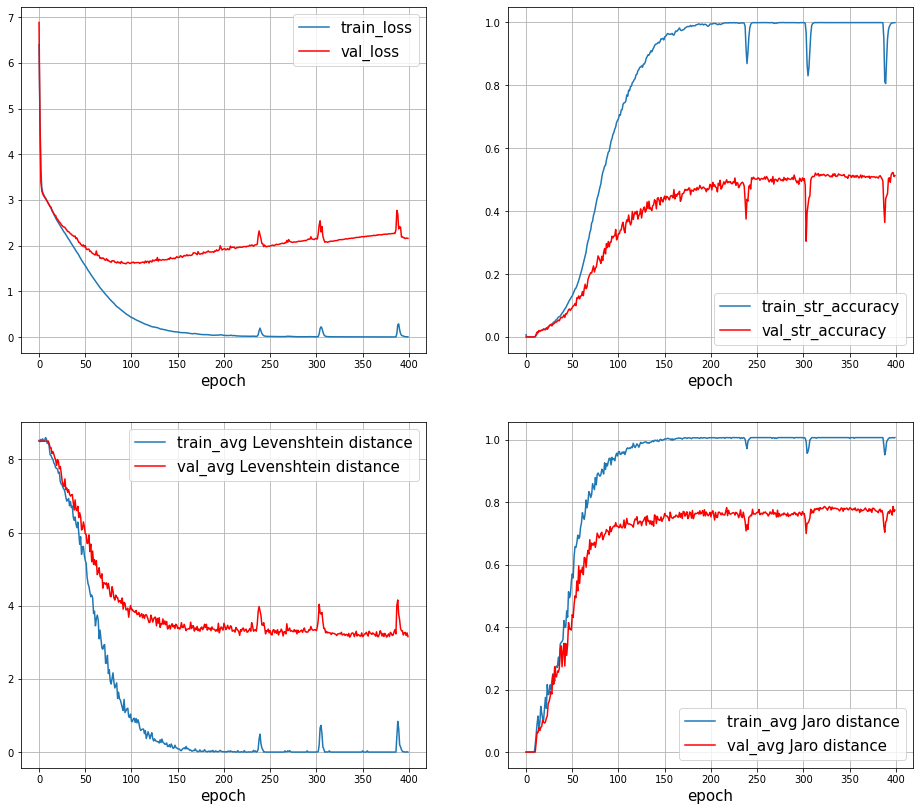

In [116]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        idx = 2*i + j
        col.plot(variables[idx], label=score_types[idx])
        col.plot(variables[idx+4], label=score_types[idx+4], color='r')
        col.legend(loc="best", fontsize=15)
        col.set_xlabel('epoch', size=15)
        col.grid()

plt.show()


## Best model selection

In [11]:
best_model = ls_logs[np.argmin(val_loss)]['model_path']

## Prediction examples

In [4]:
pics_folder = 'NumBase'
all_pics = os.listdir(pics_folder)
alphabet = "ABEKMHOPCTYX" + "".join([str(i) for i in range(10)])

In [5]:
from cnd.ocr.predictor import Predictor
from cnd.ocr.transforms import get_transforms

In [14]:
transform = get_transforms([32, 96])
predictor = Predictor('cnd'+best_model[2:])

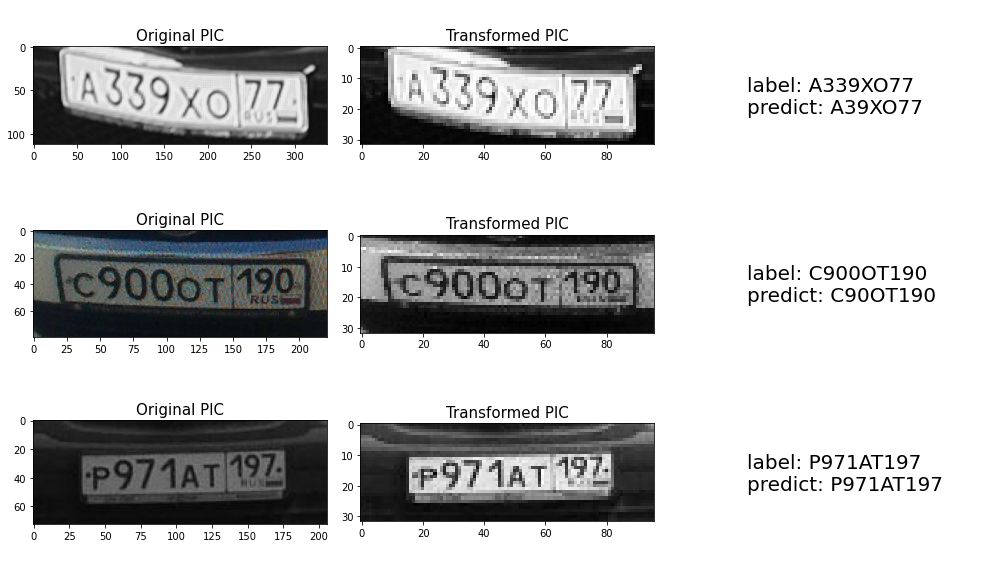

In [175]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 8))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if j == 0:
            car_path = random.choice(all_pics)
            car_number = cv2.imread('NumBase' + '/' + car_path)
            col.imshow(car_number)
            col.set_title('Original PIC', size=15)
        if j == 1:
            car_number = transform(car_number)
            col.imshow(car_number.permute(1, 2, 0)[:, :, -1], cmap='gray')
            col.set_title('Transformed PIC', size=15)
        if j == 2:
            label = car_path.split('_')[0]
            p = predictor.predict(car_number[None, :, :, :])
            col.text(0.2, 0.4, 'label: ' + label + '\n' + 'predict: ' + p, size=20)
            col.axis('off')

plt.tight_layout()
plt.show()


In [6]:
from skimage import io

In [7]:
transform = get_transforms([32, 96])
predictor = Predictor('model_crnn.pth')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

'A1114'

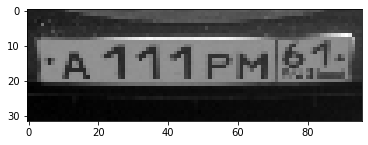

In [44]:
a = io.imread('https://i.imgur.com/IwNCRpN.png') # any URL
a = transform(a)
plt.imshow(a.permute(1, 2, 0)[:, :, -1], cmap='gray')
p = predictor.predict(a[None, :, :, :])
p